# Convert word to vector with spaCy

In [1]:
# Load spaCy model
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
# Load nouns that appear at least 1000 times
input_file = 'data/nouns_1000.txt'

nouns = []
with open(input_file, 'r') as f:
    for line in f:
        nouns.append(line[:-1])  # Remove newline
print(len(nouns))

2516


In [3]:
# Use spaCy model to get tokens
# Remove docs that have more than one token
def get_tokens(nouns):
    docs = [nlp(noun) for noun in nouns]
    tokens = [doc[0] for doc in docs if len(doc) == 1]
    return tokens

In [4]:
tokens = get_tokens(nouns)
print(len(tokens))

2514


In [5]:
# Get nouns that are in the vocabulary of the model
inv_nouns = [token for token in tokens if not token.is_oov]
print(len(inv_nouns))

2509


In [6]:
# Get vectors
vectors = [noun.vector for noun in inv_nouns]

# View words

In [7]:
vectors_20 = vectors[:20]

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vectors_20)
vectors_20_2D = pca.transform(vectors_20)

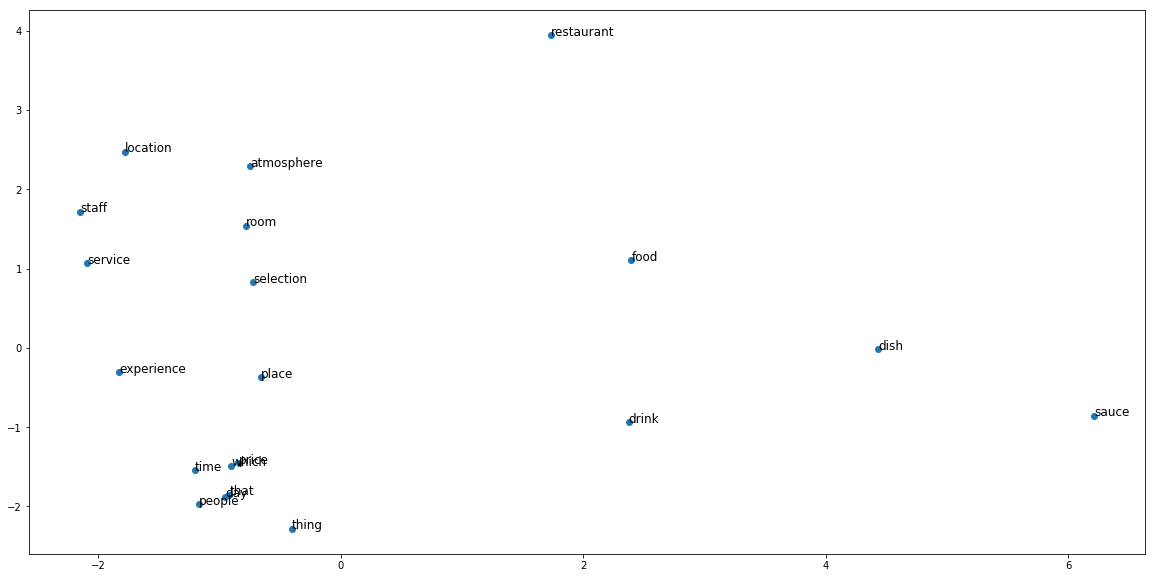

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(vectors_20_2D[:,0], vectors_20_2D[:,1])

for word, coord in zip(inv_nouns, vectors_20_2D):
    x, y = coord
    plt.text(x, y, word.text, size=12)

plt.show()

# Find relevant nouns

In [11]:
def find_noun_object(nouns, text):
    for noun in nouns:
        if noun.text == text:
            return noun

# def find_relevant_nouns(nouns, initial_nouns, threshold):
#     length_before = len(initial_nouns)
#     for noun in nouns:
#         for initial_noun in initial_nouns:
#             if noun.similarity(initial_noun) >= threshold:
#                 initial_nouns.add(noun)
#                 break
#     length_after = len(initial_nouns)
    
#     if length_before == length_after:
#         return initial_nouns
#     else:
#         return find_relevant_nouns(nouns, initial_nouns, threshold)

def find_relevant_nouns(nouns, initial_nouns, threshold):
    open_set = initial_nouns
    closed_set = set()

    while open_set:
        candidate = open_set.pop()
        for noun in nouns:
            if candidate.similarity(noun) >= threshold and noun not in closed_set:
                open_set.add(noun)
        closed_set.add(candidate)
    
    return closed_set

def get_nouns_in_aspects(nouns, aspects, threshold):
    aspects_dict = {}
    for aspect in aspects:
        obj = find_noun_object(nouns, aspect)
        initial_nouns = {obj}
        final_nouns = find_relevant_nouns(nouns, initial_nouns, threshold)
        aspects_dict[aspect] = {noun.text for noun in final_nouns}
    return aspects_dict

In [12]:
general_aspects = {
    'Food': {'food', 'drink', 'restaurant'},
    'Costs': {'price', 'value'},
    'Service': {'service', 'staff', 'server', 'waiter'},
    'Environment': {'atmosphere', 'environment'},
    'Location': {'location', 'place'}
}

from functools import reduce
aspects = reduce(lambda x, y: x.union(y), general_aspects.values())
threshold = 0.7

%time res = get_nouns_in_aspects(inv_nouns, aspects, threshold)

CPU times: user 49.8 s, sys: 805 ms, total: 50.6 s
Wall time: 50 s


In [13]:
size_before_merge = 0
for key, value in res.items():
    print(key + ': ', end='')
    print(value)
    size_before_merge += len(value)

restaurant: {'peach', 'salmon', 'delicious', 'sweet', 'blue', 'sauce', 'kebab', 'curry', 'horseradish', 'cheese', 'fudge', 'guac', 'arugula', 'mozzarella', 'chowder', 'zucchini', 'sorbet', 'scallion', 'roast', 'oatmeal', 'restaurant', 'polenta', 'sugar', 'shrimp', 'clam', 'chocolate', 'asparagus', 'kimchi', 'brioche', 'pear', 'brie', 'cupcake', 'ceviche', 'pudding', 'flavour', 'cream', 'salami', 'shawarma', 'chimichanga', 'vinegar', 'tiramisu', 'seafood', 'banana', 'lasagna', 'citrus', 'syrup', 'risotto', 'mousse', 'yogurt', 'gnocchi', 'artichoke', 'bulgogi', 'coconut', 'jalapeños', 'creme', 'asada', 'watermelon', 'tamale', 'cucumber', 'lemon', 'carpaccio', 'juice', 'pan', 'bacon', 'chive', 'icecream', 'coleslaw', 'cider', 'soup', 'skillet', 'burgers', 'cookie', 'pepper', 'catfish', 'relleno', 'crispy', 'frosting', 'rye', 'flavor', 'sundae', 'kale', 'fries', 'pepperoni', 'taco', 'edamame', 'tasty', 'flavorful', 'lettuce', 'sashimi', 'hamburger', 'burger', 'ricotta', 'cauliflower', 'sal

In [14]:
relevant_nouns = set()
for s in res.values():
    relevant_nouns = relevant_nouns.union(s)
print('Size before merge:', size_before_merge)
print('Size after merge:', len(relevant_nouns))

Size before merge: 354
Size after merge: 354


In [15]:
reverse_general_aspects = dict()
for key, values in general_aspects.items():
    for value in values:
        reverse_general_aspects[value] = key

relevant_nouns_to_aspect = dict()
for key, values in res.items():
    for value in values:
        relevant_nouns_to_aspect[value] = reverse_general_aspects[key]

import json
with open('data/relevant_nouns_to_aspect.json', 'w') as f:
    json.dump(relevant_nouns_to_aspect, f, indent=2)

In [16]:
nouns_count_file = 'data/nouns_count.txt'
nouns_count = dict()
with open(nouns_count_file, 'r') as f:
    for line in f:
        noun, count = line.split('  ')  # two spaces
        count = int(count)
        
        if noun != '-PRON-':
            nouns_count[noun] = count
sum_of_all_nouns = sum(nouns_count.values())

relevant_nouns_count = [value for key, value in nouns_count.items() if key in relevant_nouns]
sum_of_relevant_nouns = sum(relevant_nouns_count)

print('Total count for all nouns:', sum_of_all_nouns)
print('Total count for all relevant nouns:', sum_of_relevant_nouns)
print(sum_of_relevant_nouns/sum_of_all_nouns)

Total count for all nouns: 38084467
Total count for all relevant nouns: 12256514
0.32182448555732707
